In [1]:
import pyodbc
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [8]:
server = 'HOANGCS' 
database = 'CompanyX' 
username = 'hoangcs' 
password = 'hoangcs02'


cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

C:\Users\PC\AppData\Local\Temp\ipykernel_32684\670046406.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnxn)


In [9]:
# Fact Table
query = """
SELECT * FROM dbo.fact_table
WHERE [TransactionType]='S'
"""
df = pd.read_sql(query, cnxn)
df

C:\Users\PC\AppData\Local\Temp\ipykernel_32684\700479654.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnxn)


,TransactionID,ProductID,ReferenceOrderID,ReferenceOrderLineID,TimeID,ProductModelID,ProductSubcategoryID,StandardCost,ActualSellPrice,ListPrice,Quantity,TransactionType
0,100092,875,53450,1,1.0,24,23,3.3623,5.8435,8.99,4.0,S
1,100093,953,53451,2,1.0,35,3,755.1508,874.6920,1214.85,2.0,S
2,100094,965,53451,1,1.0,36,3,461.4448,534.4920,742.35,1.0,S
3,100095,712,53452,10,1.0,2,19,6.9223,5.8435,8.99,2.0,S
4,100096,885,53452,31,1.0,7,16,601.7437,742.8934,1003.91,4.0,S
...,...,...,...,...,...,...,...,...,...,...,...,...
65534,213597,707,43681,207,NaN,33,31,13.0863,20.1865,34.99,0.0,S
65535,213598,732,43681,206,NaN,16,14,352.1394,356.8980,594.83,0.0,S
65536,213599,762,43681,205,NaN,30,2,486.7066,419.4589,782.99,0.0,S
65537,213604,762,43682,226,NaN,30,2,486.7066,419.4589,782.99,-1.0,S


In [11]:
# Get product name to display for user
query = """
SELECT [ProductID],[Name] FROM dbo.dim_Product
"""
df_productname = pd.read_sql(query,cnxn)
result = pd.merge(df, df_productname, on='ProductID')
result


C:\Users\PC\AppData\Local\Temp\ipykernel_32684\1481433315.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_productname = pd.read_sql(query,cnxn)


,TransactionID,ProductID,ReferenceOrderID,ReferenceOrderLineID,TimeID,ProductModelID,ProductSubcategoryID,StandardCost,ActualSellPrice,ListPrice,Quantity,TransactionType,Name
0,100092,875,53450,1,1.0,24,23,3.3623,5.8435,8.99,4.0,S,"Racing Socks, L"
1,100237,875,53456,4,1.0,24,23,3.3623,5.8435,8.99,11.0,S,"Racing Socks, L"
2,100422,875,53460,29,1.0,24,23,3.3623,5.8435,8.99,2.0,S,"Racing Socks, L"
3,100473,875,53464,26,1.0,24,23,3.3623,5.8435,8.99,13.0,S,"Racing Socks, L"
4,100570,875,53467,4,1.0,24,23,3.3623,5.8435,8.99,4.0,S,"Racing Socks, L"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65534,213584,756,43681,220,NaN,28,2,884.7083,874.7940,1457.99,0.0,S,"Road-450 Red, 44"
65535,213558,732,43678,170,NaN,16,14,352.1394,-356.8980,594.83,2.0,S,"ML Road Frame - Red, 48"
65536,213598,732,43681,206,NaN,16,14,352.1394,356.8980,594.83,0.0,S,"ML Road Frame - Red, 48"
65537,213586,764,43681,218,NaN,30,2,486.7066,419.4589,782.99,0.0,S,"Road-650 Red, 52"


In [13]:
# Each reference order ID is treat as a reipt ID
transactions = result.groupby('ReferenceOrderID')['Name'].apply(list).values.tolist()
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
encoded_df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(encoded_df, min_support=0.014, use_colnames=True)
print(frequent_itemsets)

      support                                           itemsets
0    0.106648                                     (AWC Logo Cap)
1    0.049611                            (Bike Wash - Dissolver)
2    0.018339                                  (Classic Vest, M)
3    0.026321                                  (Classic Vest, S)
4    0.088663                            (Fender Set - Mountain)
..        ...                                                ...
107  0.014802  (Short-Sleeve Classic Jersey, XL, Classic Vest...
108  0.014146  (Hitch Rack - 4-Bike, Short-Sleeve Classic Jer...
109  0.014095  (Water Bottle - 30 oz., Short-Sleeve Classic J...
110  0.015510  (Hitch Rack - 4-Bike, Short-Sleeve Classic Jer...
111  0.014095  (Hitch Rack - 4-Bike, Classic Vest, S, AWC Log...

[112 rows x 2 columns]


In [14]:
df_ar = association_rules(frequent_itemsets, metric = "confidence", min_threshold = 0.6)
df_ar = df_ar[['antecedents','consequents','confidence']]
print(df_ar)

                                          antecedents  \
0                                   (Classic Vest, S)   
1                                  (HL Mountain Tire)   
2                                      (HL Road Tire)   
3                                  (ML Mountain Tire)   
4                                      (ML Road Tire)   
5                              (Mountain Bottle Cage)   
6                                  (Road Bottle Cage)   
7                                      (Touring Tire)   
8              (Hitch Rack - 4-Bike, Classic Vest, S)   
9                 (Hitch Rack - 4-Bike, AWC Logo Cap)   
10                    (Classic Vest, S, AWC Logo Cap)   
11  (Short-Sleeve Classic Jersey, XL, Classic Vest...   
12    (Short-Sleeve Classic Jersey, XL, AWC Logo Cap)   
13                    (Classic Vest, S, AWC Logo Cap)   
14  (Hitch Rack - 4-Bike, Short-Sleeve Classic Jer...   
15                (Hitch Rack - 4-Bike, AWC Logo Cap)   
16    (Short-Sleeve Classic Jer

      support                                           itemsets  Index
0    0.106648                                     (AWC Logo Cap)      0
1    0.049611                            (Bike Wash - Dissolver)      1
2    0.018339                                  (Classic Vest, M)      2
3    0.026321                                  (Classic Vest, S)      3
4    0.088663                            (Fender Set - Mountain)      4
..        ...                                                ...    ...
107  0.014802  (Short-Sleeve Classic Jersey, XL, Classic Vest...    107
108  0.014146  (Hitch Rack - 4-Bike, Short-Sleeve Classic Jer...    108
109  0.014095  (Water Bottle - 30 oz., Short-Sleeve Classic J...    109
110  0.015510  (Hitch Rack - 4-Bike, Short-Sleeve Classic Jer...    110
111  0.014095  (Hitch Rack - 4-Bike, Classic Vest, S, AWC Log...    111

[112 rows x 3 columns]


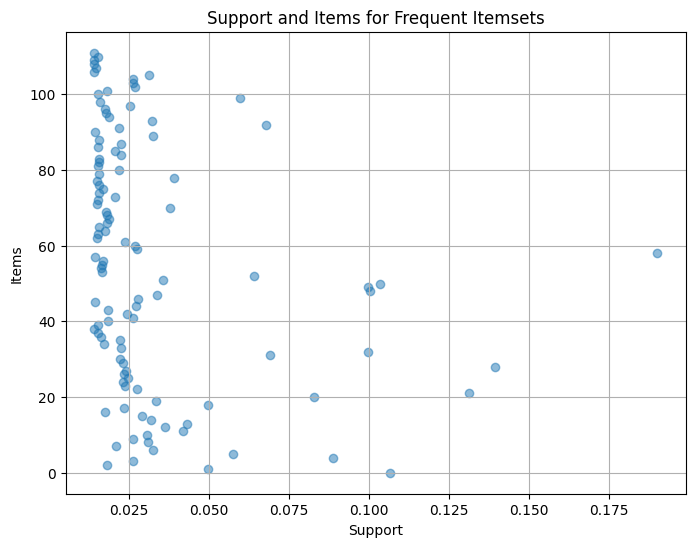

In [15]:
# Plotting the graph 
frequent_itemsets['Index'] = frequent_itemsets.reset_index().index
support = frequent_itemsets['support']
# Change the name of the product to auto increment index to display it easier
items = frequent_itemsets['Index']
print(frequent_itemsets)

plt.figure(figsize=(8, 6))
plt.scatter(support,items, alpha=0.5)
plt.xlabel('Support')
plt.ylabel('Items')
plt.title('Support and Items for Frequent Itemsets')
plt.grid(True)
plt.show()